<a href="https://colab.research.google.com/github/kkashleva/machine-learning-with-love/blob/master/Seminar_2_Workspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 2: разведочная работа, принципы анализа сообществ

В данном ноутбуке мы будем иметь дело c двумя задачами:

1. Проведение базового разведочного анализа (EDA), включая:
    1. Загрузку данных
    2. Первичную обработку данных
    3. Расчет базовых метрик и характеристик
    4. Визуализация показателей и метрик
2. Проведение анализа структуры сети --> применение метрик кластеризации (Newman, Louvain)
    1. Расчет метрик
    2. Визуализация метрик
    3. Возможный экспорт полученных данных
    
    
Нам понадобится:

- `networkx` для работы с сетевыми данными
- `matplotlib` для работы с визуализацией
- `pandas` для отгрузки некоторых результатов
- `numpy`, `statmodels` для расчета статистических метрик
- `os`, `shutil`, `request`, `zipfile`

## Описание задачи

Перед Вами встала задача анализа данных, имеющих лейбл `ia-infect-dublin`. Вам заранее известен источник загрузки данных. Вы не имеете представления о том, что именно хранится внутри данных. Ваша цель – решить задачи, представленные выше.

### «Логичная стратегия» при проведении EDA анализа

1. Произвести загрузку, распаковку и импорт данных в окружение Python.
2. С помощью методов препросмотра структуры данных попробуем понять, что там лежит
3. Выполним минимальный расчет метрик, чтобы сделать какие-то качественные выводы
4. ...
5. PROFIT!

### Приступим к работе
Для начала загрузим данные. Представим, что ни лежат на удаленном сервере. Сервер общедоступный, но файл завернут в архив. Поэтому здесь понадобится `requests` и `zipfile` для загрузки, распаковки данных и переноса в свою рабочую директорию.

Адрес данных (который как бы нам известно заранее):
1. http://nrvis.com/download/data/ia/ia-infect-dublin.zip
2. http://nrvis.com/download/data/soc/soc-FourSquare.zip

In [1]:
import os # для проверки путей
import shutil # для всяких действий
              # на системном уровне
# подгрузим модуль загрузки файлов
# и модуль для распаковки архива
# в текущее сессионное окружение
##################################
import requests
import zipfile as zp

print(os.getcwd()) # проверим наш путь, чтобы скачать архив
cur_path = os.getcwd() # потом передадим методам модуля zp

/content


In [2]:
# наш первый адрес: http://nrvis.com/download/data/ia/ia-infect-dublin.zip
sna_zip = requests.get('http://nrvis.com/download/data/ia/ia-infect-dublin.zip')
open('sna_dublin.zip', 'wb').write(sna_zip.content)

sna_unzip = zp.ZipFile('sna_dublin.zip', 'r')
sna_unzip.extractall(cur_path)

# нам нужно увидеть файл данных с расшрением *.mtx*
os.listdir()

['.config',
 'readme.html',
 'ia-infect-dublin.mtx',
 'sna_dublin.zip',
 'sample_data']

### Промежуточные наблюдения

На данном этапе мы произвели успешно загрузку и распаковку данных в нашу рабочую директорию. Мы имеем файл `ia-infect-dublin.mtx`. Расширение **`.mtx`** – один из вариантов форматов сетевых данных в `networkx`. В этом формате хранятся матрицы пересечений.

##### Небольшое отступление: типы поддерживаемых данных в пакете `networkx`

Формально говоря, `networkx` поддерживает ограниченное число типов загружаемых данных. В отличие от R, где гораздо больше возможностей для работы с графовыми данными (особенно с разнообразием в форматах хранения данных), в Python основными типами являются *текстовые* данные, *табличные* данные (подгружаемые через `pandas`) и данные с визуализатора и аналитического инструмента Gephi.

Список команд для чтения и записи данных в `networkx` можно посмотреть здесь: https://networkx.github.io/documentation/stable/reference/readwrite/index.html .

##### Про формат .mtx

Если заглянуть в эту страницу --> https://www.azfiles.ru/extension/mtx.html --> то вы узнаете, что этот формат достаточно разнороден и используется в различных ситуациях. В нашем случае под этим понимается следующее:

    файл MTX может играть роль формата представления алгебраических матриц в рамках онлайн-сервиса Matrix Market, правообладателем которого является NIST (государственное учреждение технологий и стандартов США). По своей структуре формат относится к текстовым документам в кодировке ASCII, содержащим разнородную матрицу с представлением данных в виде координат или массива. Несмотря на уникальную структуру и область применения MTX расширения, оно может быть загружено в большинство известных программ, предназначенных для автоматизации процесса алгебраических вычислений
    
Помимо этого, этот формат является родным для [**Mathworks**](https://www.mathworks.com/help/map/ref/readmtx.html), поскольку речь идет о матрице числовых данных. Anyway, перед нами текстовый файл, который можно попытаться прочитать средстами Python, но будет это крайне непросто. Поэтому воспользуемся следующим рецептом:

In [3]:
from scipy import io # содержит метода `mmread` для обрабтки таких данных
                     # с помощью метода `mminfo` можно проверить файл

sna.dt = io.mmread('ia-infect-dublin.mtx') #не воспроизведется

ValueError: ignored

Получили не очень приятную новость о том, что формат не захотел читаться. Учитывая, что функция специально разработана для данного формата – получаем "тыкву". В R с этим форматом работается гораздо приятнее и удобнее. Тем не менее, Python гораздо универсальнее R, поэтому пойдем обходным путем:

In [0]:
# вначале сконвертируем формат в txt
shutil.copy('ia-infect-dublin.mtx', 'ia-infect-dublin.mtx.2') # бэкап данных превыше всего!
shutil.copy('ia-infect-dublin.mtx.2', 'ia-infect-dublin.mtx') # чтобы не было багов дальше!
os.rename('ia-infect-dublin.mtx', 'ia-infect-dublin.txt')

In [5]:
# теперь собственно попробуем внедрить данные, но уже с помощью pandas
import pandas as pds

pds.read_csv('ia-infect-dublin.txt', delim_whitespace=False).head()

,%MatrixMarket matrix coordinate pattern symmetric
0,410 410 2765
1,14 1
2,30 1
3,63 1
4,78 1


Важно не забывать пробовать самые разные варианты. Я поиграл немного с опцией `delim_whitespace=`. Также я почитал на сайте NIST (https://math.nist.gov/MatrixMarket/formats.html) о типичной структуре данных и пришел к выводу о том, что разделителем для формата является пробел. Поэтому, чтобы извлечь максимум полезной информации – включим назад опцию `delim_whitespace = TRUE`:

In [6]:
pds.read_csv('ia-infect-dublin.txt', delim_whitespace=True).head(5)

,%MatrixMarket,matrix,coordinate,pattern,symmetric
0,410,410,2765.0,NaN,NaN
1,14,1,NaN,NaN,NaN
2,30,1,NaN,NaN,NaN
3,63,1,NaN,NaN,NaN
4,78,1,NaN,NaN,NaN


In [7]:
pds.read_csv('ia-infect-dublin.txt', delim_whitespace=True).tail(5)

,%MatrixMarket,matrix,coordinate,pattern,symmetric
2761,390,383,NaN,NaN,NaN
2762,399,384,NaN,NaN,NaN
2763,391,386,NaN,NaN,NaN
2764,398,386,NaN,NaN,NaN
2765,408,392,NaN,NaN,NaN


Теперь мы увидели, по крайней мере, 2 ключевые колонки: первую и вторую. Поскольку *у нас должно быть что-то, что напоминает сетевую структуру*, нам необходимо, по сути, вытащить данные первой и второй колонки начиная со строки 1. Заголовок при этом не представляет интереса, поскольку при чтении данных `networkx` он будет только мешать:

In [8]:
sna_dt = pds.read_csv('ia-infect-dublin.txt', delim_whitespace=True)
sna_dt[1:].head()

,%MatrixMarket,matrix,coordinate,pattern,symmetric
1,14,1,NaN,NaN,NaN
2,30,1,NaN,NaN,NaN
3,63,1,NaN,NaN,NaN
4,78,1,NaN,NaN,NaN
5,83,1,NaN,NaN,NaN


Осталось только вычленить колонки, и можно приступать к анализу:

In [9]:
sna = sna_dt[1:]
sna
# далее убираем лишние колонки
sna = sna[['%MatrixMarket','matrix']]
# переименуем колонки
sna = sna.rename(columns = {'%MatrixMarket':'col1', 'matrix':'col2'}); sna

,col1,col2
1,14,1
2,30,1
3,63,1
4,78,1
5,83,1
...,...,...
2761,390,383
2762,399,384
2763,391,386
2764,398,386


### Предварительная теория: еще раз о типах матриц

Итак, давайте еще раз вспомним о том, что есть граф.

По Харрари [1973, стр. 21] и максимально упрощенно *Граф – это набор вершин (V, vertices) и ребер (E, edges), находящихся в некотором пространсте*. Аналитически это записывается как `graph G = <V,E>`. А еще проще: это набор точек и палочек, которые могут быть замысловатым образом соединены в пространстве и представлять собой определенную уникальную структуру. Поэтому ничего не обходится в сетевом социальном анализе без рисунков (как, впрочем, и в дискретной математике). Но вернемся к тому, что важно...

У нас есть несколько видов графов. Как минимум это:

###### Простые графы

[«Simple graphs are graphs whose vertices are **unweighted, undirected, & exclusive of multiple edges & self-directed loops**»](https://towardsdatascience.com/graph-theory-set-matrix-notation-7dfb04b8ed24). Пример может быть таким (рис. ниже). Он не подписан, ни имеет стрелочек (направлений) и все вершины у него связаны. «Непростой» граф, соответственно, будет отличаться тем, что будет иметь какие-то дополнительные черты/характеристики.

![Рис. 1: Это пример простого графа](simple_graph.png)

Впрочем, какой бы граф у не был, его можно не только визуально изображать, но и табличным образом. Существует два типа *матриц* (табличного представления), по которым можно также оперелять тип данных.

1. Матрица смежности – такая матрица, в которой каждая вершина имеет однозначное и **равнозначное** соединение с другой вершиной. Если нет дополнительных характеристик, то это хороший пример просто связи между двумя объектами – например, людьми или словами в тексте. Также это позволяет косвенно указывать на то, что наш граф является *ненаправленным*, т.е. у него нет "стрелочек"-направлений от одной вершины к другой. Матрицы можно представить так:

![Рис. 1: Это пример простого графа](simple_graph_1.png)

2. Матрица инцидентности – такая матрица, в которой каждая вершинка имеет какую-то «отсылку» к другой вершинке. Такая матрица косвенно указывает нам на то, что в графе есть направления чего-то (связей, отношений, передачи чего-то) от одной вершины к другой. Такой граф будет скорее всего направленным. В табличной форме для каждой вершины по вертикали представлены пути связи (фактически ребра). Цифра 1 будет обозначть факт связи A с B либо нет.

![Рис. 1: Это пример простого графа](simple_graph_2.png)

### Принцип определения типа матрицы из исходных данных --> списки ребер

Иногда непросто понять, что перед нами за исходные данные. Матрицы смежности и инцидентности так или иначе более качественно показывают нам структуру данных, в частности связи вершин между собой. Поэтому иногда важно выяснять опытным путем, что за исходные данные мы имеем. Рассмотрим наш случай. На странице описания датасета значилось следующее:

    A human contact network where nodes represent humans and edges between them represent proximity (i.e., contacts in the physical world).

Вершины – люди, ребра – связи между людьми. Вот небольшой отрывок:

In [10]:
sna.head(50)

,col1,col2
1,14,1
2,30,1
3,63,1
4,78,1
5,83,1
6,97,1
7,120,1
8,125,1
9,130,1
10,144,1


В нашем датасете это может быть и неоднозначно. Однако *базовое правило EDA – внимательно смотреть на исходный датасет*. Давайте посмотрим еще раз (объект `sna_dt`):

In [11]:
sna_dt.head(50)

,%MatrixMarket,matrix,coordinate,pattern,symmetric
0,410,410,2765.0,NaN,NaN
1,14,1,NaN,NaN,NaN
2,30,1,NaN,NaN,NaN
3,63,1,NaN,NaN,NaN
4,78,1,NaN,NaN,NaN
5,83,1,NaN,NaN,NaN
6,97,1,NaN,NaN,NaN
7,120,1,NaN,NaN,NaN
8,125,1,NaN,NaN,NaN
9,130,1,NaN,NaN,NaN


На первой (нулевой) строчке мы видим нестандартную информацию 410-410-2765. Но если снова изучить спецификацию [NIST](https://math.nist.gov/MatrixMarket/formats.html), то нулевая строка будет обозначать **число уникальных чисел в строках, колонках и во всем массиве данных**! Запомним эту комбинацию для дальнейшей работы.

Теперь наша задача – понять, что там представлено в виде вершин, а что – ребер.

#### Формирование графа

Мы начнем с самого простого – действительно разберемся в количестве вершин и ребер. Из описания мы ожидаем, что это сеть контактов людей (возможно, в Дублине – не просто же так назван датасет на удаленном сервере?). Попробуем вычленить эти данные на рабочем массиве `sna`. Сперва сгенерируем сеть (граф) из данных:

In [12]:
import networkx as nx

# вначале удостоверимся, что за тип таблицы у нас
snag = nx.Graph(sna) # не воспроизведется

NetworkXError: ignored

Ошибка, но она полезная. Мы узнали о том, что наш файл данных является списком ребер. Теперь запомним, что список ребер имеет по крайней мере 2 колонки – откуда стартует ребро и куда примыкает. В ситуации с матрицами мы видим просто факт связи *вершин*. Соответственно, нам нужно применять методы `networkx`, которые работают со списками ребер: https://networkx.github.io/documentation/latest/reference/readwrite/edgelist.html

In [14]:
# проверим гипотезу о том, что у нас список ребер.
# Как минимум мы убеждены в том, что у нас работающий DF
nx.parse_edgelist(sna)
nx.read_edgelist(sna)

Good. У нас работающий список ребер (и, судя по подписи результата – фактический класс графа). Теперь, при загрузке данных `networkx` знает два типа данных: наименования вершин и их реберные соединения --> имеет представление о графе. Тогда попробуем проделать несколько простых метрик: посмотрим на вершины и ребра:

In [15]:
e_sna = nx.from_pandas_edgelist(sna)

KeyError: ignored

Почему не получилось (снова)? Идем снова в мануал (https://networkx.github.io/documentation/latest/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) и там видим следующее:

- df (Pandas DataFrame) – An edge list representation of a graph
- **source (str or int) – A valid column name (string or integer) for the source nodes (for the directed case)**

У нас выскочило `KeyError: 'source'`. Это значит, что `networkx` не знает название колонок. Выше было сказано, что помимо колонок с переходами от одной ноды к другой могут быть атрибутивные параметры для каждой такой пары переходов вершин. Поэтому нам надо специфицировать колонки и все получится:

In [18]:
# вначале переназовем колонки для удобства:
sna = sna.rename(columns = {'col1':'StartNode', 'col2':'EndNode'})
e_sna = nx.from_pandas_edgelist(sna, 'StartNode', 'EndNode')
print(e_sna)

Ура! Граф получился. Теперь идем проверять структуру данных на соответствие 410-410-2765: просто последовательно вызовем вершины и ребра у полученного графа:

In [19]:
e_sna.nodes()

NodeView((14, 1, 30, 63, 78, 83, 97, 120, 125, 130, 144, 157, 174, 185, 196, 210, 240, 274, 293, 305, 318, 328, 333, 342, 361, 7, 2, 39, 74, 75, 104, 116, 148, 149, 182, 200, 201, 221, 223, 235, 239, 283, 286, 291, 343, 347, 362, 366, 372, 380, 410, 6, 3, 28, 57, 96, 109, 110, 128, 129, 163, 172, 197, 229, 236, 241, 245, 249, 273, 287, 307, 398, 76, 4, 159, 252, 290, 302, 381, 393, 9, 5, 21, 58, 85, 173, 233, 335, 337, 22, 188, 214, 265, 363, 12, 51, 183, 186, 193, 216, 226, 227, 270, 282, 304, 11, 8, 43, 49, 60, 94, 162, 178, 195, 208, 217, 222, 271, 275, 278, 320, 370, 13, 29, 37, 41, 54, 61, 64, 90, 126, 179, 225, 258, 263, 277, 349, 377, 386, 402, 62, 10, 92, 385, 228, 243, 297, 392, 155, 296, 139, 262, 301, 319, 401, 32, 15, 72, 118, 134, 31, 16, 99, 151, 165, 176, 204, 218, 232, 242, 244, 336, 356, 359, 56, 17, 133, 152, 279, 330, 399, 40, 18, 59, 212, 256, 384, 146, 19, 257, 73, 20, 98, 145, 292, 376, 105, 150, 206, 364, 369, 71, 87, 100, 250, 23, 205, 231, 300, 24, 35, 25, 79, 

In [20]:
e_sna.edges()

EdgeView([(14, 1), (14, 3), (14, 5), (14, 37), (14, 41), (14, 54), (14, 90), (14, 129), (14, 139), (14, 172), (14, 225), (14, 241), (14, 258), (14, 262), (14, 301), (14, 307), (14, 319), (14, 342), (14, 398), (14, 401), (1, 30), (1, 63), (1, 78), (1, 83), (1, 97), (1, 120), (1, 125), (1, 130), (1, 144), (1, 157), (1, 174), (1, 185), (1, 196), (1, 210), (1, 240), (1, 274), (1, 293), (1, 305), (1, 318), (1, 328), (1, 333), (1, 342), (1, 361), (30, 5), (30, 27), (30, 38), (30, 97), (30, 105), (30, 132), (30, 135), (30, 144), (30, 150), (30, 196), (30, 233), (30, 240), (30, 243), (30, 274), (30, 285), (30, 293), (30, 297), (30, 318), (30, 322), (30, 326), (30, 337), (30, 342), (30, 364), (30, 400), (63, 8), (63, 34), (63, 36), (63, 67), (63, 94), (63, 121), (63, 148), (63, 154), (63, 162), (63, 178), (63, 181), (63, 192), (63, 228), (63, 255), (63, 271), (63, 305), (63, 328), (63, 347), (63, 354), (63, 357), (78, 5), (78, 21), (78, 44), (78, 58), (78, 85), (78, 97), (78, 105), (78, 144), (

А теперь сравним это с исходными данными:

In [21]:
sna.sort_values(by=['StartNode', 'EndNode']) # имена колонок недавно поменяли!

,StartNode,EndNode
51,6,3
25,7,2
81,9,5
127,11,8
107,12,7
...,...,...
2644,410,304
2727,410,343
2734,410,351
2743,410,362


In [22]:
# приведем в табличном формате данные по количеству вершин и ребер:
network_metric = pds.DataFrame({'Показатель': ['Число вершин в сети:', 'Число ребер в сети:'],
                     'Значение': [e_sna.number_of_nodes(), e_sna.number_of_edges()]})
network_metric

,Показатель,Значение
0,Число вершин в сети:,410
1,Число ребер в сети:,2765


In [23]:
# еще один способ – воспользоваться компандой info(G, n=None)
# с функцией print отображение данных будет лучше
print(nx.info(e_sna))
print("####################################")
print(nx.info(e_sna, n = 6)) # посмотреть данные для конкретной вершины
print("####################################")
print("Статус направленности графа: ", nx.is_directed(e_sna))

Name: 
Type: Graph
Number of nodes: 410
Number of edges: 2765
Average degree:  13.4878
####################################
Node 6 has the following properties:
Degree: 8
Neighbors: 3 22 96 188 214 236 265 363
####################################
Статус направленности графа:  False


Отлично. Наши расчеты совпадают с исходными. Значит, граф был опредлен `networkx` верно, и у нас действительно 410 точек (человек) и 2765 ребер (связей) между ними. Косвенно это означает, что у некоторого количества участников сети не по одной связи с другим участником. При этом у нас простой граф, потому что нет направления связей. Просто есть список тех самых связей.

## Исследование качественных характеристик графа

Продолжим EDA. Теперь нас интересуют следующие характеристики:

1. Характеристики работы сети в целом:
    1. Общая плотность сети
    2. Количество вершин и ребер (уже было посчитано)
    3. Уровень транзитивности сети
2. Характеристики сегментов сети:
    1. Центральность вершин (Total, In-Degree, Out-Degree)
    2. Уровень центральности посредничества (Betweenness Centrality)
    3. Уровень центральности (метрика Каца)
    4. ...
3. Визуализация структуры + визуализация каждой метрики
4. Складывание полученных данных в таблицу / архив визуализаций

Начнем с показателей работы сети:

###### Центральность сети

In [24]:
nx.degree(e_sna) # для каждой ноды

DegreeView({14: 20, 1: 24, 30: 25, 63: 21, 78: 19, 83: 12, 97: 17, 120: 22, 125: 22, 130: 13, 144: 20, 157: 50, 174: 14, 185: 18, 196: 10, 210: 31, 240: 15, 274: 30, 293: 19, 305: 28, 318: 32, 328: 16, 333: 33, 342: 21, 361: 13, 7: 21, 2: 26, 39: 23, 74: 20, 75: 23, 104: 27, 116: 31, 148: 43, 149: 26, 182: 24, 200: 20, 201: 21, 221: 9, 223: 25, 235: 24, 239: 25, 283: 24, 286: 33, 291: 29, 343: 24, 347: 13, 362: 27, 366: 28, 372: 43, 380: 26, 410: 31, 6: 8, 3: 23, 28: 14, 57: 13, 96: 8, 109: 11, 110: 10, 128: 11, 129: 6, 163: 23, 172: 15, 197: 9, 229: 11, 236: 26, 241: 14, 245: 12, 249: 8, 273: 16, 287: 13, 307: 14, 398: 16, 76: 27, 4: 7, 159: 19, 252: 14, 290: 14, 302: 25, 381: 16, 393: 9, 9: 29, 5: 19, 21: 21, 58: 17, 85: 15, 173: 22, 233: 16, 335: 21, 337: 23, 22: 17, 188: 10, 214: 9, 265: 3, 363: 2, 12: 17, 51: 24, 183: 17, 186: 15, 193: 28, 216: 25, 226: 27, 227: 13, 270: 23, 282: 34, 304: 47, 11: 18, 8: 18, 43: 26, 49: 14, 60: 33, 94: 27, 162: 25, 178: 25, 195: 10, 208: 22, 217: 3

In [25]:
pds.DataFrame(nx.degree(e_sna))

,0,1
0,14,20
1,1,24
2,30,25
3,63,21
4,78,19
...,...,...
405,267,5
406,203,1
407,371,4
408,313,3


(array([75., 97., 92., 62., 50., 20., 10.,  0.,  2.,  2.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

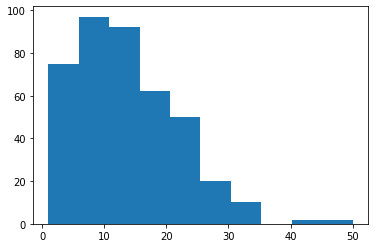

In [26]:
import matplotlib.pyplot as plt
from pylab import * # для линий

x = pds.DataFrame(nx.degree(e_sna))[0]
h = pds.DataFrame(nx.degree(e_sna))[1]

plt.hist(h)

In [27]:
pds.DataFrame(nx.degree(e_sna)).loc[27]

0    39
1    23
Name: 27, dtype: int64

In [28]:
nx.degree_histogram(e_sna)

[0,
 10,
 15,
 14,
 19,
 17,
 15,
 21,
 32,
 16,
 13,
 15,
 13,
 20,
 25,
 19,
 15,
 19,
 8,
 9,
 11,
 8,
 10,
 12,
 10,
 10,
 8,
 5,
 4,
 2,
 1,
 3,
 1,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1]

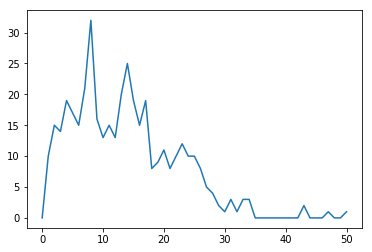

In [0]:
plot(nx.degree_histogram(e_sna))

**Что вы тут можете увидеть**?

                                        *можно вписать себе сюда*







------------------

###### Количество вершин и ребер

In [29]:
# Повторим просто
print(nx.info(e_sna))
print("####################################")
print(nx.info(e_sna, n = 6)) # посмотреть данные для конкретной вершины
print("####################################")
print("Статус направленности графа: ", nx.is_directed(e_sna))

Name: 
Type: Graph
Number of nodes: 410
Number of edges: 2765
Average degree:  13.4878
####################################
Node 6 has the following properties:
Degree: 8
Neighbors: 3 22 96 188 214 236 265 363
####################################
Статус направленности графа:  False


###### Уровень плотности сети

In [30]:
nx.density(e_sna)

print('Уровень плотности сети: ', nx.density(e_sna)*100, "%")

Уровень плотности сети:  3.2977518039239073 %


In [31]:
#  добавим в табличку:
network_metric = pds.DataFrame({'Показатель': ['Число вершин в сети: ', 'Число ребер в сети: ', 'Уровень плотности сети (%): '],
                     'Значение': [e_sna.number_of_nodes(), e_sna.number_of_edges(), nx.density(e_sna)*100]})
network_metric

,Показатель,Значение
0,Число вершин в сети:,410.000000
1,Число ребер в сети:,2765.000000
2,Уровень плотности сети (%):,3.297752


In [32]:
###### Уровень транзитивности сети
nx.transitivity(e_sna)

print('Уровень транзитивности сети: ', nx.transitivity(e_sna)*100, "%")

Уровень транзитивности сети:  43.569328760411565 %


In [34]:
#  добавим в табличку:
network_metric = pds.DataFrame({'Показатель': ['Число вершин в сети: ',
                                               'Число ребер в сети: ',
                                               'Уровень плотности сети (%): ',
                                               'Уровень транзитивности сети (%): '],
                     'Значение': [e_sna.number_of_nodes(),
                                  e_sna.number_of_edges(),
                                  nx.density(e_sna)*100,
                                  nx.transitivity(e_sna)*100]})

import openpyxl # чтобы записать в формат таблиц Excel

network_metric.to_excel('General_Attributes_Dublin.xlsx')
network_metric

,Показатель,Значение
0,Число вершин в сети:,410.000000
1,Число ребер в сети:,2765.000000
2,Уровень плотности сети (%):,3.297752
3,Уровень транзитивности сети (%):,43.569329


Можно подвести некоторые итоги: мы получили первые данные о структуре сети. Мы можем судить о том, что сеть контактов состоит из относительно большого числа участников, однако многие из них имеют достаточно широкий круг знакомств. При этом это явно не объединенная социальная группа, поскольку уровень плотности около 3%. То есть перед нами достаточно распределенная в некотором пространстве сеть людей. Если учитывать наименование файла датасета, то это отчасти справедливо. Вполне возможно, речь идет о сообществе, который проживает в Дублине и располагает каким-то общим свойством. При этом уровень транзитивности в 44% говорит нам о том, что у почти половины участников налажены контакты таким образом, что очень многие из них выступают в роли брокеров – ключевых посредников для налаживания связей. То есть в 44% случаев есть некая триада A-B-C, где A-B, B-C => A-C.

Визуализируем полученный граф:

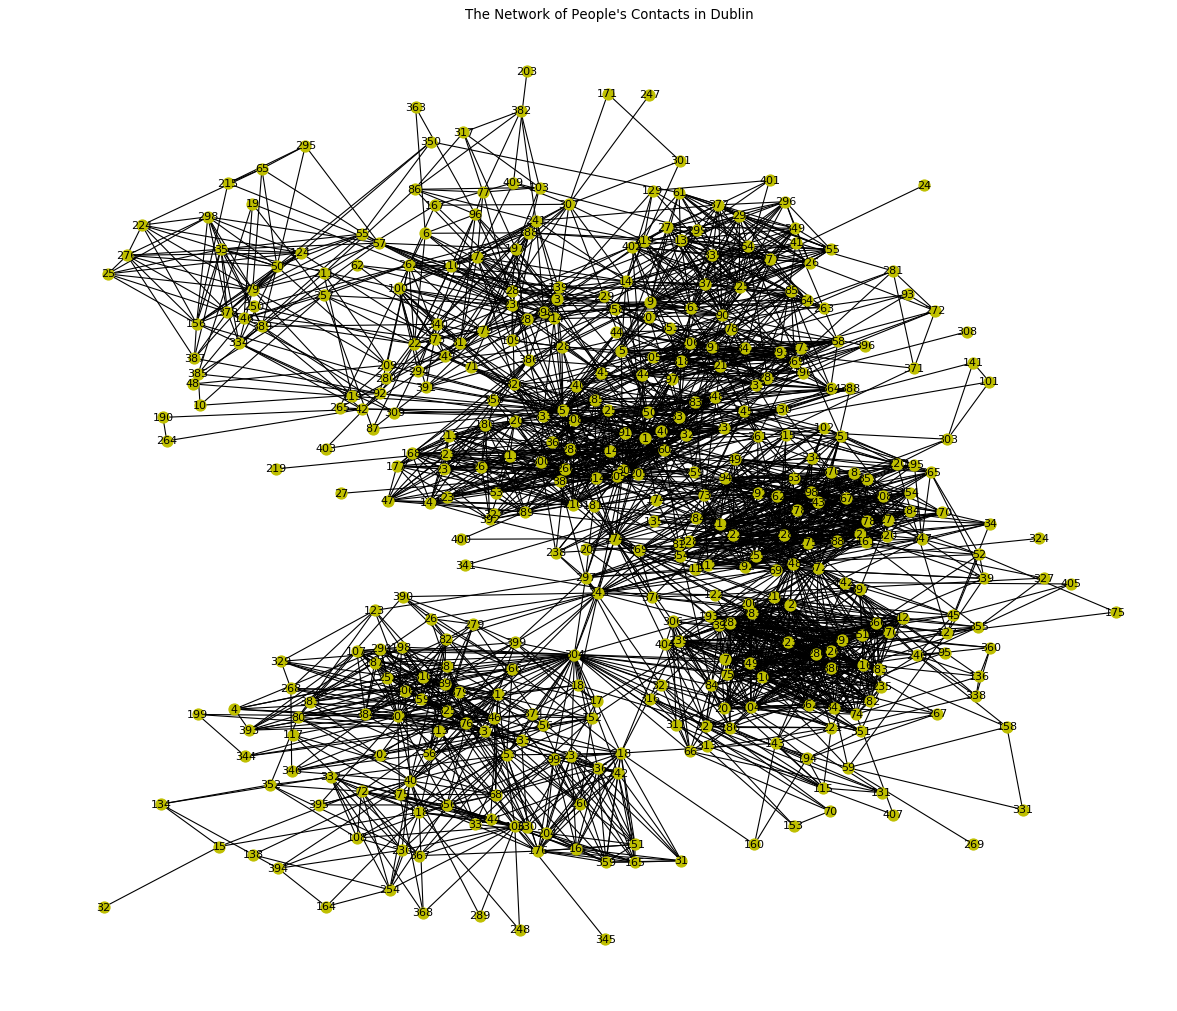

In [0]:
# Изначально рисунок будет маленький.
from matplotlib.pyplot import figure
####################################
figure(num=None, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

#nx.draw(e_sna, pos= nx.kamada_kawai_layout(e_sna))
graph_1 = nx.draw_kamada_kawai(e_sna, with_labels=True, node_size = 100, font_size = 10,
              node_color = 'y')

plt.title("The Network of People's Contacts in Dublin")
plt.savefig('Graph.pdf', format = "PDF")
plt.show()
plt.close()

## Исследование качественных характеристик внутри сети

Теперь займемся анализом характеристик уже на уровне отдельно взятых вершин и ребер. Чаще всего мы имеем дело с расчетами центральностей разного рода, визуализации функций плотности этих центральностей и (возможно) окрашивание вершин в заивисимости от показателей/метрик.

Как «обычно», начнем с расчетов всех метрик, а затем перейдем к визуализации и построению серии дополнительных графовых карт. В качестве референса используем страницу https://networkx.github.io/documentation/stable/reference/index.html, в которой представлены все основные функции пакета `networkx`.

In [0]:
# Расчет общей степени центральности, in-degree, out-degree centrality
print("1. Степень центральности графа составляет: ", nx.degree_centrality(e_sna))

1. Степень центральности графа составляет:  {14: 0.0488997555012225, 1: 0.05867970660146699, 30: 0.061124694376528114, 63: 0.05134474327628362, 78: 0.04645476772616137, 83: 0.029339853300733496, 97: 0.04156479217603912, 120: 0.05378973105134474, 125: 0.05378973105134474, 130: 0.03178484107579462, 144: 0.0488997555012225, 157: 0.12224938875305623, 174: 0.034229828850855744, 185: 0.044009779951100246, 196: 0.02444987775061125, 210: 0.07579462102689487, 240: 0.03667481662591687, 274: 0.07334963325183375, 293: 0.04645476772616137, 305: 0.06845965770171149, 318: 0.07823960880195599, 328: 0.039119804400977995, 333: 0.08068459657701711, 342: 0.05134474327628362, 361: 0.03178484107579462, 7: 0.05134474327628362, 2: 0.06356968215158924, 39: 0.05623471882640587, 74: 0.0488997555012225, 75: 0.05623471882640587, 104: 0.06601466992665037, 116: 0.07579462102689487, 148: 0.10513447432762836, 149: 0.06356968215158924, 182: 0.05867970660146699, 200: 0.0488997555012225, 201: 0.05134474327628362, 221: 0.

In [0]:
pds.DataFrame.from_dict(nx.degree_centrality(e_sna), orient = 'index').loc[27]

0    0.002445
Name: 27, dtype: float64

In [0]:
pds.DataFrame.from_dict(nx.betweenness_centrality(e_sna), orient = 'index').loc[27]

0    0.0
Name: 27, dtype: float64

In [0]:
#print("2. Степень входящей центральности графа составляет: ", nx.in_degree_centrality(e_sna))
#print("3. Степень исходящей центральности графа составляет: ", nx.out_degree_centrality(e_sna))

In [0]:
# завернем расчеты общей степени центральности в табличный формат --> pandas.DataFrame.from_dict
sna_centrality = pds.DataFrame.from_dict(nx.degree_centrality(e_sna),
                                        orient = 'index',
                                        dtype= None,
                                        columns = ['Центральность'])

sna_centrality.head()

,Центральность
14,0.048900
1,0.058680
30,0.061125
63,0.051345
78,0.046455


Итак, мы убедились в том, что смогли рассчитать только общую центральность, поскольку при попытке посчитать входящую/исходящую центральности мы получаем ошибки. Оно и понятно – **граф то у нас ненаправленный; нет стрелок от одной вершинки к другой**. Также, поскольку при использовании функции `nx.degree_centrality(e_sna))` мы получаем кашу из данных, логично их представить в табличной форме. Поэтому мы также вводим функцию `pandas.DataFrame.from_dict`. Подробнее с методом можно ознакомиться здесь: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html


Поэтому в том же духе сделаем другие расчеты:

In [0]:
# Расчет степени центральности посредничества
print("2. Степень центральности посредничества графа составляет: ", nx.betweenness_centrality(e_sna))

2. Степень центральности посредничества графа составляет:  {14: 0.015250659653607102, 1: 0.027255301195712702, 30: 0.05285121469075457, 63: 0.006053330855540605, 78: 0.0021785012547505082, 83: 0.010924536307432219, 97: 0.0016025627413445522, 120: 0.003237477112743537, 125: 0.0025244142347942457, 130: 0.0003592737739223367, 144: 0.0024506220152692684, 157: 0.19933337996818398, 174: 0.003837935207552793, 185: 0.0023006795474410516, 196: 0.0016742515738324083, 210: 0.01492038683617025, 240: 0.0017106978897931356, 274: 0.26528048246853664, 293: 0.004975349429379073, 305: 0.019259901207350837, 318: 0.014872901755270038, 328: 0.004234581143177231, 333: 0.0750688917993786, 342: 0.004331257354464487, 361: 0.01847745785068836, 7: 0.004120358629950461, 2: 0.008218211960692483, 39: 0.00642630509738346, 74: 0.0040371517560992545, 75: 0.0031169846884994343, 104: 0.0027415816121366403, 116: 0.005728533960081518, 148: 0.04131016897720382, 149: 0.00484205442547753, 182: 0.00011211957111601513, 200: 0.

In [0]:
# завернем расчеты общей степени центральности в табличный формат --> pandas.DataFrame.from_dict
sna_betweenness = pds.DataFrame.from_dict(nx.betweenness_centrality(e_sna),
                                        orient = 'index',
                                        dtype= None,
                                        columns = ['Посредничество'])

sna_betweenness.head()

,Посредничество
14,0.015251
1,0.027255
30,0.052851
63,0.006053
78,0.002179


На очереди – центральность по близости:

In [0]:
# Расчет общей центральности по близости
print("3. Степень центральности близости графа составляет: ", nx.closeness_centrality(e_sna))

3. Степень центральности близости графа составляет:  {14: 0.3065967016491754, 1: 0.36913357400722024, 30: 0.35814360770577935, 63: 0.32128829536527886, 78: 0.30095658572479767, 83: 0.32434575733544807, 97: 0.31680867544539115, 120: 0.3096139288417865, 125: 0.3138910207214121, 130: 0.2959479015918958, 144: 0.3115003808073115, 157: 0.4013738959764475, 174: 0.3399833748960931, 185: 0.3151001540832049, 196: 0.30095658572479767, 210: 0.33829611248966085, 240: 0.3217938630999213, 274: 0.41565040650406504, 293: 0.3072877535687453, 305: 0.35658238884045335, 318: 0.32408874801901744, 328: 0.33913764510779437, 333: 0.3748854262144821, 342: 0.3124522536287242, 361: 0.33745874587458746, 7: 0.3115003808073115, 2: 0.33252032520325203, 39: 0.3207843137254902, 74: 0.2786103542234332, 75: 0.3063670411985019, 104: 0.29297994269340977, 116: 0.2959479015918958, 148: 0.34897610921501704, 149: 0.31293037490436115, 182: 0.27766463000678887, 200: 0.31953125, 201: 0.2906894100923952, 221: 0.2732130928523714, 2

In [0]:
# завернем расчеты общей степени центральности в табличный формат --> pandas.DataFrame.from_dict
sna_closeness = pds.DataFrame.from_dict(nx.closeness_centrality(e_sna),
                                        orient = 'index',
                                        dtype= None,
                                        columns = ['Близость'])

sna_closeness.head()

,Близость
14,0.306597
1,0.369134
30,0.358144
63,0.321288
78,0.300957


Наконец – центральность по Катцу (либо собственный вектор). Проблема с расчетом центральности Катца заключается в оптимальном объеме итераций, необходимых для подсчетов. Иногда и 4000 итераций не хватает (как в данном случае), поэтому можно производить расчет собственного вектора.

In [0]:
# Расчет общей центральности по близости
print("4. Степень центральности (Катц) графа составляет: ", nx.eigenvector_centrality(e_sna, max_iter=4000)[243])

4. Степень центральности (Катц) графа составляет:  0.03214367760041195


In [0]:
# завернем расчеты общей степени центральности в табличный формат --> pandas.DataFrame.from_dict
sna_eigen = pds.DataFrame.from_dict(nx.eigenvector_centrality(e_sna),
                                        orient = 'index',
                                        dtype= None,
                                        columns = ['Соб. Вектор'])

sna_eigen.head()

,Соб. Вектор
14,0.001934
1,0.014897
30,0.010427
63,0.041720
78,0.003888


Теперь объединим все полученные метрики в одну таблицу:

In [0]:
nodes_properties = pds.DataFrame()

# умножим каждый элемент на 100, чтобы получить как бы проценты
nodes_properties = nodes_properties.append(sna_centrality)
nodes_properties = nodes_properties.join(sna_betweenness)
nodes_properties = nodes_properties.join(sna_closeness)
nodes_properties = nodes_properties.join(sna_eigen)

# запишем в файл
nodes_properties.to_excel('Nodes_Level_Attributes_Dublin.xlsx')

nodes_properties.sort_values(by=['Центральность'])

,Центральность,Посредничество,Близость,Соб. Вектор
247,0.002445,0.000000,0.205115,0.000023
24,0.002445,0.000000,0.214811,0.000085
27,0.002445,0.000000,0.263871,0.000446
219,0.002445,0.000000,0.240306,0.000347
32,0.002445,0.000000,0.166463,0.000004
308,0.002445,0.000000,0.245057,0.000188
269,0.002445,0.000000,0.203179,0.000713
203,0.002445,0.000000,0.195320,0.000005
345,0.002445,0.000000,0.200392,0.000075
324,0.002445,0.000000,0.258861,0.007711


Напоследок – немного визуализации. Совместим все графики в одном варианте:

In [0]:
pl1_1 = nodes_properties.reset_index()['index']
pl1_2 = nodes_properties.reset_index()['Центральность']*100
pl2_2 = nodes_properties.reset_index()['Посредничество']*100
pl3_2 = nodes_properties.reset_index()['Близость']*100
pl4_2 = nodes_properties.reset_index()['Соб. Вектор']*100

subplot(4,2,1)
hist(pl1_2)
subplot(4,2,2)
hist(pl2_2)


In [0]:
l1_2